# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com
* [slides](https://www.youtube.com/watch?v=WbYRFdxbDyI)
* [code](https://www.youtube.com/watch?v=TOZh5AIW2bw)



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [806 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea


Next, set up virtual display，and import all necessaary packages.

In [1]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

import random
from collections import namedtuple, deque

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [2]:
seed = 543 # Do not change this
def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.set_deterministic(True)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [3]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [4]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [5]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [6]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [7]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [8]:
observation, reward, done, info = env.step(random_action)

In [9]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [10]:
print(reward)

-0.8588900517154912


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

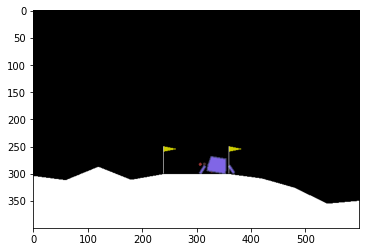

In [11]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
rewards = []
done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)
    rewards.append(round(reward, 2))

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
discounted_rewards = np.zeros_like(rewards)
R = 0.0
for i in reversed(range(len(rewards))):
    R = R * .99 + rewards[i]
    discounted_rewards[i] = round(R, 2)

In [12]:
print('The reward list', rewards)
print('The discounted reward list', discounted_rewards)
print('mean of reward', round(np.mean(np.array(rewards)), 2))
print('The final reward', round(reward, 2))
print('The number of step', len(rewards))

The reward list [2.27, -1.88, -2.42, -1.54, -2.44, -1.44, 3.22, -1.82, -1.77, 4.65, -1.53, -2.28, -1.86, -2.44, -2.46, 3.64, -2.27, -2.21, 1.02, -2.23, -1.75, 2.72, -2.54, -2.68, -1.83, 1.22, 3.06, -1.58, -1.3, -1.19, -1.98, -1.11, -1.73, -0.86, -1.6, -0.84, -1.62, -0.86, -0.41, -1.23, -0.32, -0.24, -0.87, -0.93, -1.2, -0.3, -0.5, 1.62, 4.96, -0.06, 2.07, -0.19, 0.44, -0.36, -0.53, -0.67, 0.18, 0.32, 0.51, 0.69, 6.57, 4.97, -0.25, 0.57, -0.29, 4.17, 0.34, 2.83, -0.49, 2.76, 0.7, 7.68, -100]
The discounted reward list [ -58.05  -60.93  -59.64  -57.8   -56.83  -54.94  -54.04  -57.84  -56.59
  -55.37  -60.63  -59.69  -57.99  -56.7   -54.81  -52.88  -57.09  -55.37
  -53.7   -55.27  -53.58  -52.35  -55.63  -53.62  -51.46  -50.13  -51.87
  -55.48  -54.45  -53.68  -53.02  -51.56  -50.96  -49.73  -49.36  -48.24
  -47.88  -46.73  -46.33  -46.38  -45.61  -45.75  -45.97  -45.55  -45.07
  -44.32  -44.46  -44.41  -46.49  -51.97  -52.43  -55.06  -55.42  -56.42
  -56.63  -56.67  -56.56  -57.32  -58.2

## DQN
Now, we can build a simple Q network. The network will return one of action in the action space.

In [13]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Then, we need to build a simple agent. The agent will acts according to the output of the Q network above. There are a few things can be done by agent:
- `learn()`：update the local Q network, which is compute Q value on this step.
- `act()`：After receiving observation from the environment, utilize Q network to tell which action to take. The probability of action will be getten. Hence, there is a epsilon-greedy to decide choose by greedy or random.
- `soft_update`: update target Q network, which compute Q value on next step.

In [14]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 2        # how often to update the network
CLIP_GRAD_NORM = 0.8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # -------------------- update network -------------------- #
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                idxs, is_weight, experiences = self.memory.sample()
                self.learn(experiences, GAMMA, idxs, is_weight)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma, idxs, is_weights):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        # loss = F.mse_loss(Q_expected, Q_targets)
        loss = (torch.FloatTensor(is_weights) * F.mse_loss(Q_expected, Q_targets)).mean()

        # update priority by td error
        errors = torch.abs(Q_expected.detach() - Q_targets).data.squeeze().tolist()
        self.memory.update(idxs, errors)

        # Minimize the loss
        # -------------------- update local network -------------------- #
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), CLIP_GRAD_NORM)
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def get_mem_parms(self):
        alpha, beta = self.memory.get_parm()
        return alpha, beta

#### Replay memory

In [15]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    # store in a array of size (2 * capacity - 1)
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object) # custom dtype
        self.n_entries = 0
        # [--------------Parent nodes-------------][-------leaves to recode priority-------]
        #             size: capacity - 1                       size: capacity
        # [--------------data frame-------------]
        #             size: capacity

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for transitions
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

\begin{equation*}
P(i)=\frac{p_{i}^{\alpha}}{\sum_{k} p_{k}^{\alpha}} \quad w_{i}=\left(\frac{1}{N} \cdot \frac{1}{P(i)}\right)^{\beta}
\end{equation*}

In [17]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        # self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.tree =  SumTree(buffer_size)

        self.buffer_size = buffer_size
        self.prio_max = 0.1
        self.alpha = 1.0
        self.e = 0.01
        self.beta = 0.5
        self.beta_growth_rate = 1.005
        self.alpha_decay_rate = 0.995

        self.update_cnt = 0
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        data = self.experience(state, action, reward, next_state, done)
        p = (np.abs(self.prio_max) + self.e) ** self.alpha #  proportional priority
        self.tree.add(p, data)
        # self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        states_lst, actions_lst, rewards_lst, next_states_lst, dones_lst = [], [], [], [], []
        idxs = []
        segment = self.tree.total() / self.batch_size
        priorities = []

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, p, ex = self.tree.get(s)
            if ex is not None:
                states_lst.append(ex.state)
                actions_lst.append(ex.action)
                rewards_lst.append(ex.reward)
                next_states_lst.append(ex.next_state)
                dones_lst.append(ex.done)
                priorities.append(p)
                idxs.append(idx)
                
            
        states = torch.from_numpy(np.vstack(states_lst)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions_lst)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards_lst)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states_lst)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones_lst).astype(np.uint8)).float().to(device)


        # experiences = random.sample(self.memory, k=self.batch_size)

        # states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        # actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        # rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        # next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        # dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        if self.update_cnt % 200 == 0:
            self.beta = np.min([1., self.beta*self.beta_growth_rate])
            self.alpha = np.max([0.5, self.alpha*self.alpha_decay_rate])
        self.update_cnt += 1

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return idxs, is_weight, (states, actions, rewards, next_states, dones)

    def update(self, idxs, errors):
        self.prio_max = max(self.prio_max, max(np.abs(errors)))
        for i, idx in enumerate(idxs):
            p = (np.abs(errors[i]) + self.e) ** self.alpha
            self.tree.update(idx, p) 

    def __len__(self):
        """Return the current size of internal memory."""
        return self.tree.n_entries

    def get_parm(self):
        return self.alpha, self.beta

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [18]:
n_episodes=1500     # maximum number of training episodes
max_t=1000          # maximum number of timesteps per episode
eps_start=1.0       # starting value of epsilon, for epsilon-greedy action selection
eps_end=0.01        # minimum value of epsilon
eps_decay=0.995     # multiplicative factor (per episode) for decreasing epsilon

agent = Agent(state_size=8, action_size=4)

scores = []                        # list containing scores from each episode
final_rewards = []                 # list containing scores from final reward
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
score_best = 0.0

for i_episode in range(1, n_episodes+1):
    state = env.reset()
    score = 0
    for t in range(max_t):
        action = agent.act(state, eps)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            final_rewards.append(reward)
            break 
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    alpha, beta = agent.get_mem_parms()
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tepsilon-greedy: {:.4f}\talpha: {:.3f}, \tbeta: {:.3f}'.format(i_episode, np.mean(scores_window), eps, alpha, beta))
    if np.mean(scores_window)>=score_best+5:
        print('Environment saved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
        score_best = np.mean(scores_window).item()
        if np.mean(scores_window)>=280.0:
            print('Environment saved in {:d} episodes!\tAverage Score: {:.2f} <-- exceed baseline'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break

# final step
if np.mean(scores_window)>=score_best:
    print('Environment saved in {:d} episodes!\tAverage Score: {:.2f} <-- final step'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')

Episode 100	Average Score: -186.92	epsilon-greedy: 0.6058	alpha: 0.869, 	beta: 0.575
Episode 200	Average Score: -137.30	epsilon-greedy: 0.3670	alpha: 0.701, 	beta: 0.712
Episode 300	Average Score: -57.44	epsilon-greedy: 0.2223	alpha: 0.500, 	beta: 1.000
Environment saved in 350 episodes!	Average Score: 5.58
Environment saved in 357 episodes!	Average Score: 14.07
Environment saved in 364 episodes!	Average Score: 22.52
Environment saved in 367 episodes!	Average Score: 28.51
Environment saved in 370 episodes!	Average Score: 33.84
Environment saved in 372 episodes!	Average Score: 39.41
Environment saved in 375 episodes!	Average Score: 45.40
Environment saved in 378 episodes!	Average Score: 52.48
Environment saved in 380 episodes!	Average Score: 59.06
Environment saved in 390 episodes!	Average Score: 64.24
Environment saved in 393 episodes!	Average Score: 71.13
Environment saved in 398 episodes!	Average Score: 77.18
Episode 400	Average Score: 80.56	epsilon-greedy: 0.1347	alpha: 0.500, 	beta

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


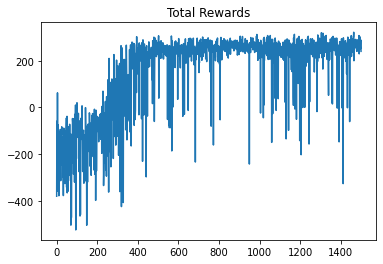

In [19]:
plt.plot(scores)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


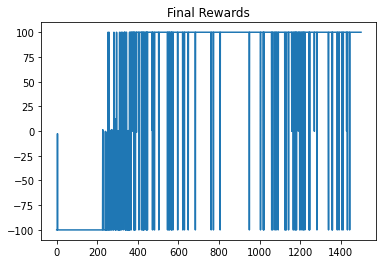

In [20]:
plt.plot(final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


264.66701410914305
286.91914632757727
288.4411187986955
249.15327020716876
286.4744654246649


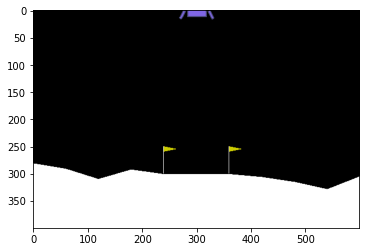

In [21]:
fix(env, seed)
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
# agent.network.eval()  # set the network into evaluation mode
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action = agent.act(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

    #   img.set_data(env.render(mode='rgb_array'))
    #   display.display(plt.gcf())
    #   display.clear_output(wait=True)
      
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) # save the result of testing 

In [22]:
print(np.mean(test_total_reward))

275.1310029734499


Action list

In [23]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[0, 0, 0, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 0, 2, 0, 2, 2, 3, 2, 2, 1, 3, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 3, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 2, 1, 3, 2, 0, 3, 1, 2, 3, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 3, 2, 0, 2, 0, 2, 2, 2, 3, 2, 2, 3, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 3, 2, 2, 2, 2, 0, 2, 0, 2, 3, 2, 2, 0, 2, 0, 3, 2, 0, 2, 0, 2, 2, 0, 3, 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Analysis of actions taken by agent

In [24]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{0: 458, 1: 78, 3: 185, 2: 522}


Saving the result of Model Testing


In [25]:
PATH = "Action_List.npy" # Can be modified into the name or path you want
np.save(PATH ,np.array(action_list)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### This is the file you need to submit !!!
Download the testing result to your device



In [26]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Server 
The code below simulate the environment on the judge server. Can be used for testing.

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


Your reward is : 264.67
Your reward is : 286.92
Your reward is : 288.44
Your reward is : 249.15
Your reward is : 286.47


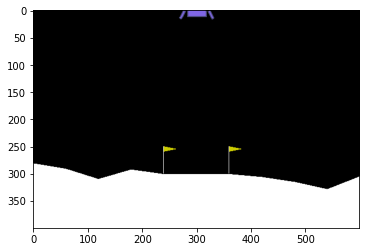

In [27]:
action_list = np.load(PATH,allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

# agent.network.eval()  # set network to evaluation mode
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False

  for action in actions:
  
      state, reward, done, _ = env.step(action)
      total_reward += reward
      if done:
        break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# Your score

In [28]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 275.13


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)


## Reference
* [Reference code](https://github.com/ranjitation/DQN-for-LunarLander)
* [clearly! best!](https://medium.com/%E9%9B%9E%E9%9B%9E%E8%88%87%E5%85%94%E5%85%94%E7%9A%84%E5%B7%A5%E7%A8%8B%E4%B8%96%E7%95%8C/%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-ml-note-reinforcement-learning-%E5%BC%B7%E5%8C%96%E5%AD%B8%E7%BF%92-dqn-%E5%AF%A6%E4%BD%9Catari-game-7f9185f833b0)
* [clearly second best!](http://debussy.im.nuu.edu.tw/sjchen/MachineLearning/final/DeepRL.pdf)
* [value based](https://zhuanlan.zhihu.com/p/25239682)
* [入門到放棄](https://zhuanlan.zhihu.com/p/21378532)
* [priority](https://zhuanlan.zhihu.com/p/128176891)
* [priority github](https://github.com/rlcode/per/blob/44b42eedbcc452fbe8be221f6597955a706c20cf/prioritized_memory.py)<br>
* [priority with weight loss](https://towardsdatascience.com/how-to-implement-prioritized-experience-replay-for-a-deep-q-network-a710beecd77b)
* [Mofan](https://mofanpy.com/tutorials/machine-learning/reinforcement-learning/)

